In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [2]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

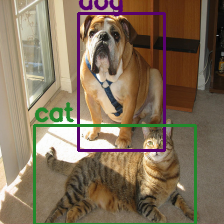

In [3]:
import requests
import torchvision
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn

image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
image = draw_boxes(boxes, labels, classes, image)

# Show the image:
Image.fromarray(image)

In [4]:
def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

In [5]:
class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
    assign a score on how the current bounding boxes match it,
        1. In IOU
        2. In the classification score.
    If there is not a large enough overlap, or the category changed,
    assign a score of 0.

    The total score is the sum of all the box scores.
    """
    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

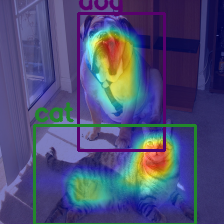

In [6]:
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)

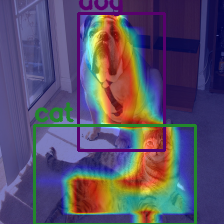

In [7]:
def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        images.append(img)
    
    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes

Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

In [8]:
from collections import OrderedDict
# from pytorch_grad_cam import AblationLayer

class AblationLayerFasterRCNN(AblationCAM):
    def __init__(self):
        super(AblationLayerFasterRCNN, self).__init__()

        def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
            """ Extract the next batch member from activations,
                and repeat it num_channels_to_ablate times.
            """
            self.activations = OrderedDict()
            for key, value in activations.items():
                fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
                self.activations[key] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x):
        """ Go over the activation indices to be ablated, stored in self.indices.
            Map between every activation index to the tensor in the Ordered Dict from the
            FPN layer.
        """
        result = self.activations
        layers = {0: '0', 1: '1', 2: '2', 3: '3', 4: 'pool'}
        num_channels_to_ablate = result['pool'].size(0)
        for i in range(num_channels_to_ablate):
            pyramid_layer = int(self.indices[i]/256)
            index_in_pyramid_layer = int(self.indices[i] % 256)
            result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000
        return result

100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


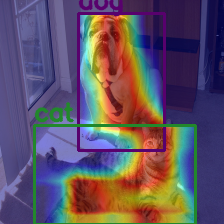

In [9]:
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN())

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


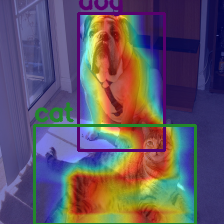

In [10]:
ratio_channels_to_ablate = 0.1
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN(),
               ratio_channels_to_ablate=ratio_channels_to_ablate)

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


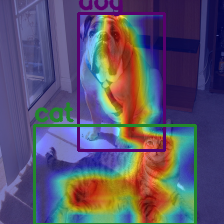

In [11]:
ratio_channels_to_ablate = 0.01
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN(),
               ratio_channels_to_ablate=ratio_channels_to_ablate)

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))